# Local Interaction

**Tomohiro Kusano**  
*Graduate School of Economics, University of Tokyo*

This notebook demonstrates how to study local interaction model using the **`localint`** Python library.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
from __future__ import division
from localint import LocalInteraction
from IPython.display import Image
import io
import base64
from IPython.display import HTML

**Note:** We don't use `%matplotlib inline` here because if use it, `animation`, which is a function defined in this notebook, doesn't work in ordinary environment.

## Local Interaction Game

Let $\chi$ be a finite set of players and $P:\chi \times \chi \to \mathbb{R}_+$ be a function such that

* $P(x,x) = 0$ for all $x \in \chi$
* $P(x,y) = P(y,x)$ for all $x,y \in \chi$.

A *local interaction system* is the undirected graph induced by $(\chi, P)$. Note that $P$ can be represented by a matrix, which will be introduced as "adjacency matrix" in the next section, since $\chi$ is finite here.


For example, $(\chi, P)$, where $\chi = {0,1,2}$ and 

\begin{equation*}
P =
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & 2 \\
3 & 0 & 0
\end{bmatrix}
\end{equation*}


represents the following local interaction system.

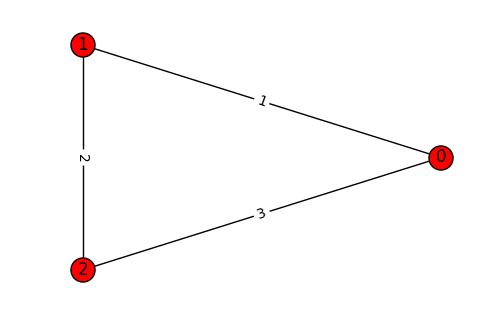

In [2]:
Image(filename='./localint_materials/figure_1.png')

The integer on each edge denote the corresponding weight on the edge.

In each period, given the local interaction system, each player plays a game constructing his/her belief, which is a distribution on the action space, according to the weights on the edges and what other players are taking.

For example, let's consider the above system. Suppose that each player has two actions (0 and 1), and Player 1, 2 are taking action 0, 1 respectively. Given the system and other players' action, Player 0 constructs a belief $(1, 3)$, which means the ratio of the probability that Player 0 meets a player taking action 0 to the probability that Player 0 meets a player taking action 1 is 1:3.

## The `LocalInteraction` class

The **`LocalInteraction`** class requires two parameters, **payoff matrix** and **adjacency matrix**.

### Payoff Matrix

Payoff matrix must be 2-dimensional square numpy array.   In a game-theoretic model, it means that both the set of actions and the payoff function are the same across all players.

For instance, consider a coordination game where the payoff table is given by the following:

1$\backslash$2 | $A$           | $B$ 
 ------------- |---------------| ---------
 $A$           | 4, 4          |    0, 2   
 $B$           | 2, 0          |   3, 3       

Note that this payoff table implies that the game is symmetric. Because of the symmetricity, it suffices to record the only one of the player's payoffs like the following:

In [87]:
payoff_matrix = np.asarray([[4, 0], 
                            [2, 3]])
print payoff_matrix

[[4 0]
 [2 3]]


### Adjacency Matrix

Adjacency matrix represents how the nodes in the system are connected. In particular, in the context of the local interaction model, it represents whether each pair of players interacts and how strong the interaction of them is if they are connected.

Let's consider an adjacency matrix given by the following:
\begin{equation}
[a_{ij}] = 
\begin{bmatrix}
0 &1 &3\\
2 &0 &1\\
3 &2 &0
\end{bmatrix}
\end{equation}

In [88]:
adj_matrix = np.asarray([[0, 1, 3],
                         [2, 0, 1],
                         [3, 2, 0]])
print adj_matrix

[[0 1 3]
 [2 0 1]
 [3 2 0]]


For example, $a_{12}(=1)$ denotes the weight on player 2's action to player 1. Note that the weight on player 1's action  player 2 ($a_{21}=2$) is different. That is, the **`LocalInteraction`** class allow adjacency matrix to be asymmetric unlike payoff matrix.

### Creating a `LocalInteraction`

Now that we have two parameters, `payoff_matrix` and `adj_matrix`, we can create a `LocalInteraction`:

In [89]:
li = LocalInteraction(payoff_matrix, adj_matrix)

In [92]:
li.players[0]

Player in a 2-player normal form game with payoff matrix:
[[4, 0], [2, 3]]

The adjacency matrix is saved in the form of [`csr_matrix`](https://docs.scipy.org/doc/scipy-0.15.1/reference/sparse.html).

In [93]:
li.adj_matrix

<3x3 sparse matrix of type '<type 'numpy.int32'>'
	with 6 stored elements in Compressed Sparse Row format>

### Initializing current actions

Originally, current actions are $N$-dimensional zero vector, where $N =$ "the number of players".

In [95]:
li.N, li.current_actions

(3, array([0, 0, 0]))

To initialize `current_actions`, we can use `set_init_actions`:

In [96]:
init_actions = [1, 0, 1]
li.set_init_actions(init_actions)

In [97]:
li.current_actions

array([1, 0, 1])

If we don't specify the list of the players' actions, `set_init_actions` randomly set `current_actions`.

In [100]:
li.set_init_actions()

In [101]:
li.current_actions

array([1, 1, 0])

## Examples

In this section, we give you a couple of examples for typical graphs, and analyze the local interaction models corresponding to those graphs.

In order to show those results graphically, we have to define functions to draw a graph and generate an animation.

In [2]:
def draw_graph(graph_dict, figsize=(16,10), node_size=200, linewidth=2):
    fig = plt.figure(figsize=figsize, facecolor='w')
    nx.draw_networkx_nodes(graph_dict['G'], graph_dict['pos'],
                           node_size=node_size, node_color='w')
    nx.draw_networkx_edges(graph_dict['G'], graph_dict['pos'],
                           alpha=0.5, width=linewidth, arrows=False)
    plt.axis('off')
    plt.show()

In [3]:
def animation(li, init_actions=None, pos='circular', node_size=200,
              node_colors=None, linewidth=2, interval=200, figsize=(16,10)):
    num_actions = li.num_actions

    if node_colors is None:
        node_colors = mpl.rcParams['axes.color_cycle']
    num_colors = len(node_colors)
    if num_colors < num_actions:
        raise ValueError('{0} colors required '.format(num_actions) +
                         '(only {0} provided)'.format(num_colors))

    G = nx.DiGraph(li.adj_matrix)

    if isinstance(pos, dict):
        pos = pos
    else:
        try:
            layout_func = getattr(nx, '{0}_layout'.format(pos))
            pos = layout_func(G)
        except:
            raise ValueError(
                "pos must be a dictionary of node-position pairs, or one of " +
                "{'circular', 'random', 'shell', 'spring', 'spectral'}")

    def get_fig(n):
        for i in range(num_actions):
            nodelist = np.where(li.current_actions == i)[0].tolist()
            nx.draw_networkx_nodes(G, pos, node_size=node_size,
                                   nodelist=nodelist,
                                   node_color=node_colors[i])
        li.play()
        return fig

    li.set_init_actions(init_actions)

    fig = plt.figure(figsize=figsize, facecolor='w')
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=linewidth, arrows=False)
    anim = FuncAnimation(fig, get_fig, interval=interval)
    plt.axis('off')
    plt.show()
    plt.close()

### 2-actions case

For convenience, we focus on a coordination game, which is given by the following:

In [11]:
coordination_game = np.array([[11, 0],
                              [9, 8]])

Also, let `node_colors_2` be a list whose $i$-th ($i = 0, 1$) element denotes a color of players taking action $i$:

In [12]:
node_colors_2 = ['b', 'y']

Actually, in this case, the action 1, which leads to the risk-dominant but inefficient outcome if both players take it, is *contageous* in some sense although we don't formally define it. You would see what it means in the following section before long.

#### Circle

We first examine one of the simplest graph, called "circle graph".

In [13]:
N = 100
circle = {}
G = nx.cycle_graph(n=N)
circle['G'] = G
circle['adj_matrix'] = nx.adjacency_matrix(G)
circle['pos'] = nx.circular_layout(G)

Note that we have to specify not only the graph and the adjacency matrix but also positions of nodes since `draw_graph` and `animation` require it.

In [7]:
draw_graph(circle)

In [14]:
li_coor = LocalInteraction(coordination_game, circle['adj_matrix'])

In [15]:
init_actions = np.zeros(li_coor.N, dtype=int)
init_actions[[0, -1]] = 1
animation(li_coor, init_actions=init_actions, pos=circle['pos'],
          node_colors=node_colors_2, interval=100)

You can see that the distribution of the players taking action 1 is spreaded across all nodes as time goes on.

#### Two-dimensional lattice

We next examine another simple graph, called "Two-dimensional lattice". Actually, Its procedure for simulation is the same as the circle graph, except for that it is tedious to specify the positions of nodes in this case.

In [16]:
N = 100
lattice2d = {}
m, n = 10, 10
G = nx.grid_2d_graph(m, n)
lattice2d['adj_matrix'] = nx.adjacency_matrix(G)
lattice2d['G'] = nx.Graph(lattice2d['adj_matrix'])
lattice2d['pos'] = {}
for i, (x, y) in enumerate(G.nodes_iter()):
    lattice2d[(x, y)] = i 
    lattice2d['pos'][i] = (x/(m-1), y/(n-1))

In [7]:
draw_graph(lattice2d)

In [85]:
li_coor = LocalInteraction(coordination_game, lattice2d['adj_matrix'])

In [86]:
# m, n = 10, 10
init_actions = np.zeros(li_coor.N, dtype=int)
for node in [(m//2-i, n//2-j) for i in range(2) for j in range(2)]:
    init_actions[lattice2d[node]] = 1
animation(li_coor, init_actions=init_actions, pos=lattice2d['pos'],
          node_colors=node_colors_2, figsize=(14,8), interval=500)

### 3-actions case

The `localint` module works even in 3-actions case. Let's consider the following game, which is called "Bilingual Game":

In [32]:
def bilingual_game(e, a=11, b=0, c=9, d=8):
    A = np.array([[a  , a  , b],
                  [a-e, a-e, d-e],
                  [c  , d  , d]])
    return A

In [33]:
bg = bilingual_game(e=0.1)
bg

array([[ 11. ,  11. ,   0. ],
       [ 10.9,  10.9,   7.9],
       [  9. ,   8. ,   8. ]])

In [102]:
node_colors_3 = ['b', 'r', 'y']

We show that even the action 0, which leads to Pareto efficient outcome, can be contagious in this case. 

#### Circle

In [39]:
li_bg = LocalInteraction(bg, circle['adj_matrix'])

In [65]:
init_actions = np.ones(li_bg.N, dtype=int) * 2
init_actions[[0, 1, -2, -1]] = 0
animation(li_bg, init_actions=init_actions, pos=circle['pos'],
          node_colors=node_colors_3, interval=100)

#### Two-dimensional lattice

In [67]:
li_bg = LocalInteraction(bg, lattice2d['adj_matrix'])

In [82]:
# m, n = 10, 10
init_actions = np.ones(li_bg.N, dtype=int) * 2
for node in [(m//2-i, n//2-j) for i in range(2) for j in range(2)]:
    init_actions[lattice2d[node]] = 0
animation(li_bg, init_actions=init_actions, pos=lattice2d['pos'],
          node_colors=node_colors_3, interval=500)